In [1]:
val transactionsDf = spark.read.json("s3://unwind.dev.data/nft/ko/*/all/").cache
//val transactionsDf = spark.read.json("s3://unwind.dev.data/nft/ko/0xABB3738f04Dc2Ec20f4AE4462c3d069d02AE045B/all/").cache

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
7,application_1663108617445_0008,spark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

transactionsDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [block_hash: string, block_number: bigint ... 15 more fields]


In [ ]:
//transactionsDf.filter($"owner_address".isNotNull).show(false)

In [ ]:
// transactionsDf.
//   filter($"type" === "mint").
//   groupBy("transaction_hash", "contract_address").
//   agg(countDistinct("owner_address").as("cnt")).
//   filter($"contract_address" === "0xabb3738f04dc2ec20f4ae4462c3d069d02ae045b").
//   show(false)

In [ ]:
// transactionsDf.
//   select(countDistinct("transfer_to"), countDistinct("transfer_from"), countDistinct("owner_Address")).
//   show

In [ ]:
// transactionsDf.
//   groupBy("type").
//   agg(count("*").as("cnt")).
//   show

In [ ]:
// transactionsDf.
//   filter($"type" === "sale").
//   select("buyer_address", "transfer_to", "marketplace").
//   show(false)

In [2]:
val editionDf = transactionsDf.
  filter($"type" === "mint").
  groupBy("transaction_hash").
  agg(count("*").as("edition_total"), min("token_id").as("edition_id")).
  cache

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

editionDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [transaction_hash: string, edition_total: bigint ... 1 more field]


In [ ]:
//transactionsDf.filter($"token_id" === "10642000").orderBy($"transaction_date").select("type", "transaction_date", "transaction_hash").show(false)

In [ ]:
// transactionsDf.
//   filter($"type" === "mint").
//   select("token_id", "transaction_hash").
//   show(false)

In [ ]:
//transactionsDf.select("token_id").distinct.count

In [3]:
val tokensWithEditionDf = transactionsDf.
  filter($"type" === "mint").
  select("token_id", "transaction_hash").distinct.
  join(editionDf, "transaction_hash").
  select("edition_total", "edition_id", "token_id").
  cache 
  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

tokensWithEditionDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [edition_total: bigint, edition_id: string ... 1 more field]


In [4]:
tokensWithEditionDf.count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res3: Long = 99813


In [4]:
val metaDfRaw = spark.read.json("s3://unwind.dev.data/nft/ko/*/meta/").dropDuplicates("token_id").cache
//val metaDfRaw = spark.read.json("s3://unwind.dev.data/nft/ko/0xABB3738f04Dc2Ec20f4AE4462c3d069d02AE045B/meta/").cache

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

metaDfRaw: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [animation_url: string, cached_animation_url: string ... 8 more fields]


In [9]:
metaDfRaw.count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res6: Long = 93275


In [5]:
metaDfRaw.groupBy("metadata.attributes.theme").
  agg(count("*").as("cnt")).
  orderBy($"cnt".desc).
  show(false)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-----+
|theme        |cnt  |
+-------------+-----+
|null         |27149|
|Abstract     |6986 |
|Conceptual   |6286 |
|Surreal      |5882 |
|Illustration |5401 |
|Animation    |4607 |
|Portrait     |3275 |
|Pop art      |2897 |
|Cultural     |2792 |
|Dark         |2170 |
|surreal      |2147 |
|dark         |2011 |
|illustration |1793 |
|Spiritual    |1667 |
|conceptual   |1441 |
|portrait     |1406 |
|Expressionism|1356 |
|Nature       |1234 |
|abstract     |1219 |
|animation    |1019 |
+-------------+-----+
only showing top 20 rows



In [ ]:
//metaDfRaw.filter($"metadata.attributes.asset_type" === "video/mp4").show(false)

In [ ]:
// metaDfRaw.
// //filter($"metadata.attributes.asset_type" === "video/mp4").
// filter($"cached_file_url".isNull).
// show(false)

In [5]:
val oldEditionDf = metaDfRaw.
  filter($"contract_address" === "0xfbeef911dc5821886e1dda71586d90ed28174b7d").
  groupBy("metadata.image").
  agg(min("token_id").as("old_edition_id"), countDistinct("token_id").as("old_edition_total")).
  withColumn("old_edition_id", ($"old_edition_id" - 1).cast("int").cast("string")).
  cache
  

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

oldEditionDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [image: string, old_edition_id: string ... 1 more field]


In [ ]:
//oldEditionDf.printSchema

In [6]:
val metaDf = metaDfRaw.join(tokensWithEditionDf, "token_id").
  withColumn("image", $"metaData.image").
  join(oldEditionDf, Seq("image"), "left").
  withColumn("edition_id", coalesce($"old_edition_id", $"edition_id")).
  withColumn("edition_total", coalesce($"old_edition_total", $"edition_total")).
  drop("image", "old_edition_id", "old_edition_total").
  cache

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

metaDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [token_id: string, animation_url: string ... 10 more fields]


In [ ]:
// metaDf.
//   withColumn("edition_id", coalesce($"old_edition_id", $"edition_id")).
//   withColumn("edition_total", coalesce($"old_edition_total", $"edition_total")).
//   drop("image", "old_edition_id", "old_edition_total").
//   show


In [ ]:
//metaDf.filter($"metaData.image" === "https://ipfs.infura.io/ipfs/QmRFjLMJJ8zoaksu4gKus2wjYxJoq7x3NKetJ21hnZvi7g/asset.jpeg").
//select("metadata.attributes.artist", "token_id", "metadata.name").show(false)

In [ ]:
// metaDf.groupBy("metaData.image").
//   agg(countDistinct("edition_id").as("edition_cnt"), min("edition_id").as("edition_id")).
//   //filter($"edition_cnt" === 1).
//   orderBy($"edition_cnt".desc).show(1000, false)

In [ ]:
//metaDf.select("metaData.image").distinct.count

In [ ]:
//metaDf.filter($"token_id" === "22001" || $"token_id" === "22002").
// metaDf.filter($"metaData.image" === "https://ipfs.infura.io/ipfs/Qme5AbzusmNopDwyNGFdZQuRQsHPMdMMoP5YMkfyK21Ssq/asset.gif").
// select("metadata_url", "token_id", "metadata.name", "file_url").
// show(false)

In [ ]:
//metaDf.count

In [ ]:
// metaDf.select("contract_address").distinct.show(false)

In [ ]:
//metaDf.select("metadata.attributes.artist").distinct.count

In [7]:
val transactionsWithMetaDf = transactionsDf.
  filter(($"type" === "transfer" && $"transfer_to" =!= "0x000000000000000000000000000000000000dead") || ($"type" === "mint" && $"contract_address" === "0xfbeef911dc5821886e1dda71586d90ed28174b7d") || $"type" === "sale").
  withColumn("transfer_to", coalesce($"transfer_to", $"buyer_address", $"owner_address")).
  withColumn("token_id", coalesce($"token_id", $"nft.token_id")).
  join(metaDf, "token_id").
  dropDuplicates("transfer_to", "transaction_hash", "edition_id").
  withColumn("timestamp", $"transaction_date".cast("timestamp").cast("long")).
  cache

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

transactionsWithMetaDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [token_id: string, block_hash: string ... 27 more fields]


In [10]:
transactionsWithMetaDf.count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res7: Long = 61758


In [9]:
transactionsWithMetaDf.
  groupBy($"transfer_to", $"edition_id").
  agg(count("*").as("wt")).
  orderBy($"wt".desc).
  show(false)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------+----------+---+
|transfer_to                               |edition_id|wt |
+------------------------------------------+----------+---+
|0x24fc3694928acfcf4c08d7771d1b2e64b44b53a7|9854000   |200|
|0x37ec905b4b508292c63a294c648a346413167eaf|9854000   |199|
|0x1e6c2d786bc1ce71e8fc27451c31ba6713c00f23|4644000   |50 |
|0x1e6c2d786bc1ce71e8fc27451c31ba6713c00f23|3757000   |46 |
|0x899b2685c26f51d9f15933f2c26706c2f24c6b85|2197000   |43 |
|0x899b2685c26f51d9f15933f2c26706c2f24c6b85|4643000   |41 |
|0x899b2685c26f51d9f15933f2c26706c2f24c6b85|3803000   |41 |
|0x121bf018c4260ff74d1a223fa3f5faa26140f986|50700     |34 |
|0x406f4533b2f6209812d7ef9c7d69b8c54217c208|54800     |32 |
|0x7895e668bd43c9623af538f274c06cb22cbc74f2|6271000   |27 |
|0x1e6c2d786bc1ce71e8fc27451c31ba6713c00f23|2197000   |27 |
|0x73186b2a81952c2340c4eb2e74e89869e1183df0|134850    |25 |
|0x73186b2a81952c2340c4eb2e74e89869e1183df0|139800    |25 |
|0x73186b2a81952c2340c4eb2e74e89869e1183

In [8]:
val washTradingBaseDf = transactionsWithMetaDf.as("a").
  join(transactionsWithMetaDf.as("b"), Seq("token_id")).
  filter($"a.transaction_date" < $"b.transaction_date" && $"a.transfer_to" === $"b.transfer_from").
  withColumn("timestamp_delta", $"b.timestamp" - $"a.timestamp").
  groupBy($"token_id", $"b.transaction_date", $"b.transfer_from").
  agg(min($"timestamp_delta").as("timestamp_delta"), first("b.edition_id").as("edition_id"), first("b.metadata.attributes.artist").as("artist")).
  cache

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

washTradingBaseDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [token_id: string, transaction_date: string ... 4 more fields]


In [9]:
washTradingBaseDf.
  groupBy("edition_id", "transfer_from").
  agg(count("*").as("trades")).
  createOrReplaceTempView("agg")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
%%sql
select * from agg
order by trades desc
limit 100

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [11]:
transactionsWithMetaDf.
  filter($"edition_id" === "2197000").
  groupBy("transfer_to", "transfer_from").
  agg(count("*").as("trades")).
  coalesce(1).
  write.option("header",true).csv("s3://unwind.dev.data/nft/output/ko/new/transfer_graph/2197000")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
transactionsWithMetaDf.filter($"transfer_to" === "0x24fc3694928acfcf4c08d7771d1b2e64b44b53a7" && $"transfer_from" === "0x37ec905b4b508292c63a294c648a346413167eaf").select("transaction_hash").show(false)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------------------------------+
|transaction_hash                                                  |
+------------------------------------------------------------------+
|0x71f610c1835d55fe96391b3719379f1f00d24b4c34e4e515a459da5d0c2b874c|
|0xc731962a4dd977c28bb5a1705e29de08667fe13dfe57bd0c3193ec17e22f1880|
|0x86112320e62a2382fa8bf43c927ee5edab17b84e50a8433aba96d4a733c2a577|
|0xc181cba691d0bcc28a151bdd7199059a7e36ff0991a533130dd920d09d34e906|
|0xc2b0707b830ac6b075c0169144021e25f5c409355471acb49d5bc06fd4307c4f|
|0x4624beec87df34437a01b70186b0dae8ea80b2ed14a5ae1e2d7758eba2f10b81|
|0x787262b72c040363b902bcad21d0072002593495ac476e43a05d6db2a13fa510|
|0xd1eed3f05b23d0adfb75e5456603cd5a9b2b383454d489aa2491e404878daa21|
|0xfaeb266244e2d1f4888f0737b4a8f53f632b3d0c3ce02087032e1d4696c5afc9|
|0xc6c6733969f85e1de6748df66a2b59b2e1569632f9bf3e81ec27ed47a0de996d|
|0x71d5929e23cd667ccabaf47274b8fc8afd1175c067228922e7f0baa590bd2ac3|
|0xe72b5da4d27fd2673121870828722d4

In [9]:
transactionsWithMetaDf.filter($"transfer_to" === $"transfer_from").select("transaction_hash").show(false)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------------------------------+
|transaction_hash                                                  |
+------------------------------------------------------------------+
|0x90c710fe904402b19900e31f4fd54ffa384a11582b1b2b47dc7b17e0f9730316|
|0x50206859819c554db7ae5fdd13cdd2569bf2017cd4c3395c9bf60ce70a54ca56|
|0x5cc3cb61e1fb62bce8e3c4c35da44f19e97d4bf4619af84bbb44dfbb5f0571fb|
|0x6053385fa77f7ebbd0488c7cf786ece396b3f65b3cc6044e36ea5e6b28479b6a|
|0xb5d92988f62582037d60c4e37a48065adc82701b3483852b3b2654b5f7229dd0|
|0x6b555292736b6013dbaab5f5100de5fdde4172c2f7ff6fb4bdc4fd51021c75ae|
|0x3e59fe21322b3bf9eea8c45b4e42f140af187d2a4f6cba6a9224bd84dc070a99|
|0x1087b17aa1cea7e54d1a77f012cec918a625125e3704f305dc438e2b0ec77852|
|0x126043b9ec312c0b4d104f0546db689ed2f9d800857370662c614bb9803883eb|
|0x1bd8fac690195dbfe5c6f1e1f9d685415a3890a46a8dbc4450caeb32c864750e|
|0xfabe8ace61d0094891c2c752179b81c5c5482867800045aa45e4384185554d4f|
|0xb8aa0f5af8f8c8d882061406339a9cd

In [53]:
washTradingBaseDf.
  withColumn("minutes", lit(10) * ($"timestamp_delta" / 600).cast("int")).
  filter($"minutes" < 10080).  
  withColumn("minutes", when($"minutes" < 1440, $"minutes").otherwise(1440)).
  groupBy("minutes").
  agg(count("*").as("trades")).
  createOrReplaceTempView("agg")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [60]:
%%sql
select * from agg


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [19]:
transactionsWithMetaDf.
  filter($"transfer_to" === "0x899b2685c26f51d9f15933f2c26706c2f24c6b85" && $"token_id" === "2197005").
  orderBy($"transaction_date".asc).
  select("transaction_date", "transaction_hash", "marketplace").
  show(false)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------------------------------------------------------------+-----------+
|transaction_date   |transaction_hash                                                  |marketplace|
+-------------------+------------------------------------------------------------------+-----------+
|2022-04-01T15:48:30|0xbbf564def370f60bed3c49b3403105c9cac4a8da35e9ce7e05d9ac014b741c37|null       |
|2022-04-01T16:25:48|0xcc59f0e6d945dd5c9c6cec1cd68f293dfa5af2cfaa7e1db45dd572fff309b5f0|null       |
|2022-04-01T16:29:52|0x683d21a9a5cabcb0cd68fce5fb98c58817a89a3d766ae30fcaac1c08bd1d2374|null       |
|2022-04-01T16:46:17|0x4b3e47696c8ee8e6d43347d72f0f5892de63bfca7cf79222e6fcfd4e45e27dba|null       |
|2022-04-01T16:54:28|0xeb5976886edbdfb2707c52e5e01c69991e1393de05f1b9588e2031af9d9a95ff|null       |
|2022-04-01T17:23:33|0x4bb6a6b138f11df39dd7747b99bb46a64b76c68f43b51f0717bf40274d92685d|null       |
|2022-04-01T17:33:10|0x92eb4251f11dfdb9919043a55f3633c47c10a9641160b344f20dca750ddffac4|nul

In [27]:
transactionsWithMetaDf.show

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------------------+------------+-------------+--------------------+--------------+-----------+----+--------------------+-------------+--------+--------------+-------------------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+----------+
|token_id|          block_hash|block_number|buyer_address|    contract_address|lister_address|marketplace| nft|       owner_address|price_details|quantity|seller_address|   transaction_date|    transaction_hash|       transfer_from|         transfer_to|    type|       animation_url|cached_animation_url|     cached_file_url|   chain|    contract_address|            file_url|            metadata|        metadata_url|        updated_date|edition_total|edition_id|
+--------+--------------------+------------+-------------+------------

In [12]:
transactionsDf.
  filter(($"type" === "transfer" && $"transfer_to" =!= "0x000000000000000000000000000000000000dead") || ($"type" === "mint" && $"contract_address" === "0xfbeef911dc5821886e1dda71586d90ed28174b7d") || $"type" === "sale").
  withColumn("transfer_to", coalesce($"transfer_to", $"buyer_address", $"owner_address")).
  withColumn("token_id", coalesce($"token_id", $"nft.token_id")).join(metaDf, "token_id").count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res9: Long = 68877


In [18]:
//metaDfRaw.filter($"token_id" === 9686019).show(false)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------+--------+------------------------------------------+---------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [10]:
transactionsWithMetaDf.
  withColumn("month", substring($"transaction_date", 0, 7)).
  groupBy("month").
  agg(countDistinct("transaction_hash").as("transactions")).
  orderBy($"month".desc).
  createOrReplaceTempView("agg")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
%%sql
select * 
from agg
where month < '2022-08'
order by month desc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

In [ ]:
// transactionsDf.
//   filter(($"type" === "transfer" && $"transfer_to" =!= "0x000000000000000000000000000000000000dead") || ($"type" === "mint" && $"contract_address" =!= "0xabb3738f04dc2ec20f4ae4462c3d069d02ae045b") || $"type" === "sale").
//   withColumn("transfer_to", coalesce($"transfer_to", $"buyer_address", $"owner_address")).
//   withColumn("token_id", coalesce($"token_id", $"nft.token_id")).
// join(metaDf, "token_id").groupBy("transfer_to", "transaction_hash", "edition_id").agg(count("*").as("cnt")).
// orderBy($"cnt".desc).show(false)

In [ ]:
// transactionsWithMetaDf.groupBy("transfer_to", "transaction_hash").
//   agg(count("*").as("cnt")).
//   orderBy($"cnt".desc).
//   show(false)


In [9]:
import org.apache.spark.sql.expressions.Window

//row_number
val windowSpec  = Window.partitionBy("artist").orderBy($"wallet_count".desc)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

import org.apache.spark.sql.expressions.Window
windowSpec: org.apache.spark.sql.expressions.WindowSpec = org.apache.spark.sql.expressions.WindowSpec@32b1293f


In [10]:
val editionRankDf = transactionsWithMetaDf.
  groupBy("edition_id").
  agg(count("*").as("sales_count"), countDistinct("transfer_to").as("wallet_count")).
  withColumn("w_rank", row_number.over(Window.orderBy($"wallet_count".desc))).
  cache

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

editionRankDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [edition_id: string, sales_count: bigint ... 2 more fields]


In [ ]:
//editionRankDf.filter($"edition_id" === 173225).show(false)

In [11]:
val popularEditionsByArtist = transactionsWithMetaDf.
  dropDuplicates("edition_id").
  select("edition_id", "metadata.attributes.artist", "metadata.name", "token_id", "cached_file_url").
  join(editionRankDf, "edition_id").
  withColumn("rank", row_number.over(windowSpec)).
  filter($"rank" < 10).
  cache

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

popularEditionsByArtist: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [edition_id: string, artist: string ... 7 more fields]


In [ ]:
// transactionsWithMetaDf.dropDuplicates("edition_id").
//   filter($"edition_id" === "173225").show

In [17]:
popularEditionsByArtist.
  coalesce(1).
  write.json("s3://unwind.dev.data/nft/output/ko/new/popular_edition_by_artist/")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
transactionsWithMetaDf.
  groupBy("metadata.attributes.artist").
  agg(count("*").as("sales_count"), countDistinct("transfer_to").as("wallet_count")).
  orderBy($"wallet_count".desc).
  coalesce(1).
  write.json("s3://unwind.dev.data/nft/output/ko/new/popular_artist/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
//transactionsWithMetaDf.filter($"metadata.attributes.artist".isNull).count

In [16]:
val transactionsWithEditionRankDf = transactionsWithMetaDf.
  withColumn("contract", metaDf("contract_address")).
  withColumn("artist_name", metaDf("metadata.attributes.artist")).
  join(editionRankDf, "edition_id").
  withColumn("transaction_edition", concat($"transaction_hash", $"edition_id")).  
  cache

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

transactionsWithEditionRankDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [edition_id: string, token_id: string ... 32 more fields]


In [13]:
transactionsWithEditionRankDf.select("transfer_to", "transaction_edition").distinct.count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res9: Long = 61758


In [17]:
transactionsWithEditionRankDf.
  groupBy("contract").
  agg(countDistinct("transaction_edition")).
  show(false)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------------------+-----------------------------------+
|contract                                  |count(DISTINCT transaction_edition)|
+------------------------------------------+-----------------------------------+
|0xfbeef911dc5821886e1dda71586d90ed28174b7d|40302                              |
|0xabb3738f04dc2ec20f4ae4462c3d069d02ae045b|21400                              |
+------------------------------------------+-----------------------------------+



In [19]:
transactionsWithEditionRankDf.
  select("transaction_edition", "transfer_to", "contract", "token_id", "edition_id", "metadata.name", "artist_name", "transaction_hash", "transaction_date", "metadata.artist", "cached_file_url", "w_rank", "wallet_count").
  withColumnRenamed("transfer_to", "walletId").
  withColumnRenamed("transaction_date", "timestamp").
  coalesce(1).
  write.json("s3://unwind.dev.data/nft/output/ko/new/wallet_transfer/")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
// val artistTupleDf = transactionsWithMetaDf.
//   withColumn("artist1", $"metadata.attributes.artist").
//   withColumn("thash1", $"transaction_hash").
//   withColumn("timestamp1", $"transaction_date").
//   select("artist1", "thash1", "transfer_to", "timestamp1").
//   join(transactionsWithMetaDf.
//     withColumn("artist2", $"metadata.attributes.artist").
//     withColumn("thash2", $"transaction_hash").
//     withColumn("timestamp2", $"transaction_date").   
//     select("artist2", "thash2", "transfer_to", "timestamp2"), "transfer_to").
//   filter($"thash1" =!= $"thash2" && $"timestamp1" < $"timestamp2").
//   cache


In [ ]:
// artistTupleDf.
//   groupBy("artist1", "artist2").
//   agg(count("*").as("sales_count"), countDistinct("transfer_to").as("wallet_count")).
//   withColumn("artist_tuple", concat($"artist1", lit(" -> "), $"artist2")).
//   coalesce(1).
//   write.json("s3://unwind.dev.data/nft/ko/0xABB3738f04Dc2Ec20f4AE4462c3d069d02AE045B/artist_artist/")

In [ ]:
// artistTupleDf.
//   groupBy("artist1", "artist2").
//   agg(count("*").as("sales_count"), countDistinct("transfer_to").as("wallet_count")).
//   withColumn("artist_tuple", concat($"artist1", lit(" -> "), $"artist2")).
//   cache.
//   createOrReplaceTempView("agg")

In [ ]:
// %%sql
// select * 
// from agg
// order by wallet_count desc
// limit 10


In [ ]:
// transactionsWithMetaDf.
//   groupBy("edition_id").
//   agg(count("*").as("sales_count"), countDistinct("transfer_to").as("wallet_count")).
//   orderBy($"wallet_count".desc).
//   coalesce(1).
//   write.json("s3://unwind.dev.data/nft/ko/0xABB3738f04Dc2Ec20f4AE4462c3d069d02AE045B/top_editions/")

In [ ]:
// val editionTupleDf = transactionsWithMetaDf.
//   withColumn("edition1", $"edition_id").
//   withColumn("thash1", $"transaction_hash").
//   withColumn("timestamp1", $"transaction_date").
//   select("edition1", "thash1", "transfer_to", "timestamp1").
//   join(transactionsWithMetaDf.
//     withColumn("edition2", $"edition_id").
//     withColumn("thash2", $"transaction_hash").
//     withColumn("timestamp2", $"transaction_date").   
//     select("edition2", "thash2", "transfer_to", "timestamp2"), "transfer_to").
//   filter($"thash1" =!= $"thash2" && $"timestamp1" < $"timestamp2").
//   cache


In [ ]:
//editionTupleDf.count

In [ ]:
// val editionAggDf = editionTupleDf.
//   groupBy("edition1", "edition2").
//   agg(count("*").as("sales_count"), countDistinct("transfer_to").as("wallet_count")).
//   withColumn("edition_tuple", concat($"edition1", lit(" -> "), $"edition2")).
//   cache
  //coalesce(1).
  //write.json("s3://unwind.dev.data/nft/ko/0xABB3738f04Dc2Ec20f4AE4462c3d069d02AE045B/artist_artist/")

In [ ]:
// editionAggDf.
//   coalesce(1).
//   write.json("s3://unwind.dev.data/nft/ko/0xABB3738f04Dc2Ec20f4AE4462c3d069d02AE045B/edition_edition/")

In [ ]:
// spark.read.json("s3://unwind.dev.data/nft/ko/0xABB3738f04Dc2Ec20f4AE4462c3d069d02AE045B/edition_edition/").
//   orderBy($"wallet_count".desc).show

In [ ]:
//editionAggDf.createOrReplaceTempView("agg")

In [ ]:
// %%sql
// select * 
// from agg
// order by wallet_count desc
// limit 10

In [ ]:
// transactionsWithMetaDf.
//   groupBy("token_id").
//   agg(count("*").as("t")).
//   withColumn("transactions", lit(1) * ceil($"t"/1)).
//   groupBy("transactions").
//   agg(count("*").as("tokens")).
//   createOrReplaceTempView("agg")
  

In [ ]:
// %%sql
// select * from agg
// order by transactions desc

In [ ]:
// transactionsWithMetaDf.
//   groupBy("token_id").
//   agg(count("*").as("t")).
//   orderBy($"t".desc).
//   show

In [20]:
val repeatByersDf = transactionsWithMetaDf.
  groupBy("transfer_to").
  agg(countDistinct("transaction_hash").as("t")).
  cache

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

repeatByersDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [transfer_to: string, t: bigint]


In [ ]:
// repeatByersDf.
//   withColumn("tn", when($"t" >= 100, lit(100)).otherwise($"t")).
//   groupBy("tn").
//   agg(count("*").as("wallets")).
//   withColumn("%_of_total_wallets", lit(100.0) * $"wallets" / 17460).
//   withColumn("transactions", when($"tn" >= 100, lit("100+")).otherwise($"tn".cast("string"))).
//   createOrReplaceTempView("agg")

In [22]:
repeatByersDf.
  withColumn("tn", when($"t" >= 100, lit(100)).otherwise($"t")).
  groupBy("tn").
  agg(count("*").as("wallets")).
  orderBy($"tn").
  coalesce(1).
  write.csv("s3://unwind.dev.data/nft/output/ko/new/repeat")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
repeatByersDf.
  count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res19: Long = 15960


In [ ]:
repeatByersDf
  filter($"t" === 1).
  count

In [24]:
repeatByersDf.select(max($"t")).show

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+
|max(t)|
+------+
|   762|
+------+



In [ ]:
// %%sql
// select * from agg
// order by tn

In [25]:
transactionsWithMetaDf.
  groupBy("metadata.attributes.artist").
  agg(count("*").as("t")).
  orderBy($"t".desc).
  show(false)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----+
|artist          |t   |
+----------------+----+
|Alex Shell      |1858|
|XCOPY           |1773|
|Hulki Okan Tabak|1288|
|Kozachok        |1270|
|Mad Monk        |1163|
|Stina Jones     |1058|
|sabet           |895 |
|Gary Cartlidge  |833 |
|foodmasku       |772 |
|Benji Connell   |690 |
| Difelice5000   |680 |
|obxium          |572 |
|Brad Damico     |534 |
|Moxarra Gonzalez|534 |
|ROBNESSV2       |532 |
|Yura Miron      |517 |
|ilan katin      |504 |
|Mattia Cuttini  |493 |
|Lucho Poletti   |476 |
|Voke            |471 |
+----------------+----+
only showing top 20 rows



In [ ]:
//metaDf.filter($"metadata.artist" === "0x8e04f3f772b4250c060e1b87fd28e420999699e7").select("metadata.attributes.artist").show(false)

In [ ]:
// transactionsWithMetaDf.
//   groupBy("transfer_to", "metadata.artist").
//   agg(count("*").as("t")).
//   filter($"t" > 1).
//   withColumn("transactions", lit(5) * ceil($"t"/5)).
//   groupBy("transactions").
//   agg(count("*").as("artist_buyers")).
//   createOrReplaceTempView("agg")

In [ ]:
// transactionsWithMetaDf.
//   groupBy("transfer_to", "metadata.artist").
//   agg(count("*").as("t")).
//   filter($"t" > 1).
//   select(countDistinct("transfer_to")).
//   show


In [ ]:
// %%sql
// select * from agg
// order by transactions desc

In [ ]:
// transactionsWithMetaDf.
//   groupBy("transfer_to").
//   agg(count("*").as("t"), countDistinct("metadata.artist").as("artists")).
//   filter($"t" > 1).
//   withColumn("transactions", lit(5) * ceil($"t"/5)).
//   groupBy("transactions").
//   agg(expr("percentile(artists, array(0.5))").alias("artist_med")).
//   select($"transactions", explode($"artist_med").as("artist_med")).
//   createOrReplaceTempView("agg")

In [ ]:
// %%sql
// select * from agg
// order by transactions desc

In [ ]:
// transactionsWithMetaDf.
//   groupBy("transfer_to").
//   agg(count("*").as("t"), countDistinct("metadata.artist").as("artists")).
//   filter($"t" > 1).
//   withColumn("transactions", lit(5) * ceil($"t"/5)).

In [ ]:
// transactionsWithMetaDf.
//   groupBy("metadata.artist").
//   agg(count("*").as("t")).
//   filter($"t" > 1).
//   withColumn("transactions", lit(5) * ceil($"t"/5)).
//   groupBy("transactions").
//   agg(count("*").as("artists")).
//   createOrReplaceTempView("agg")

In [ ]:
// %%sql
// select * from agg
// order by transactions desc

In [ ]:
// %%sql
// select * from agg
// order by transactions desc

In [26]:
// transactionsWithMetaDf.
//   filter($"metadata.attributes.artist".isNull).
//   count

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

res22: Long = 213


In [ ]:
// transactionsWithMetaDf.
//   groupBy("edition_id").
//   agg(count("*").as("t")).
//   filter($"t" > 1).
//   withColumn("transactions", lit(5) * ceil($"t"/5)).
//   groupBy("transactions").
//   agg(count("*").as("editions")).
//   createOrReplaceTempView("agg")
// //   filter($"t" > 1).
// //   withColumn("transactions", lit(5) * ceil($"t"/5)).
// //   groupBy("transactions").
// //   agg(count("*").as("artists")).
// //   createOrReplaceTempView("agg")

In [ ]:
// %%sql
// select * from agg
// order by transactions desc

In [ ]:
// transactionsWithMetaDf.
//   filter($"transfer_to" === "0x239014c706e253e84a1529159b98a6e7f50d601c" && $"token_id" === "245884").
//   select("metadata.name", "metadata.artist", "metadata.attributes.artist").
//   show(false)
// //   groupBy("edition_id", "transfer_to", "token_id").
// //   agg(count("*").as("t")).
// //   filter($"t" > 1).
// //   orderBy($"t".desc).
// //   select("transfer_to", "edition_id", "token_id", "t").show(false)

In [ ]:
// metaDf.
//   select(explode($"metadata.attributes.tags").as("tag")).
//   groupBy("tag").
//   agg(count("*").as("t")).
//   orderBy($"t".desc).
//   show(100) 

In [ ]:
//import pyspark.pandas

  //withColumn("data", struct($"contract", $"token_id", $"transaction_hash", $"type", $"artist")).
  //to_pandas()

In [15]:
%%local
import boto3

bucket = 'unwind.dev.data'
s3_file_key = 'nft/output/ko/new/wallet_transfer/part-00000-5079efe5-947d-45e3-b8ba-ad5b1504abac-c000.json'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=s3_file_key)

data = obj['Body'].iter_lines()

table = boto3.resource('dynamodb', 'us-east-1').Table('qc-unwind-platform-TransactionsByWalletV3')

In [18]:
%%local

import json
for d in data:
  table.put_item(Item=json.loads(d))

  

In [ ]:
// val editionEdgeDf = spark.read.
//   json("s3://unwind.dev.data/nft/ko/0xABB3738f04Dc2Ec20f4AE4462c3d069d02AE045B/edition_edition/").cache

In [ ]:
// editionEdgeDf.
//   groupBy("edition1").
//   agg(countDistinct("edition2").as("cnt")).
//   orderBy($"cnt".desc).
//  show



In [19]:
%%local
import boto3

bucket = 'unwind.dev.data'
s3_file_key = 'nft/output/ko/new/popular_edition_by_artist/part-00000-deb93a1c-2529-4a26-bab2-d77483a8cbc0-c000.json'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=s3_file_key)

data = obj['Body'].iter_lines()

table = boto3.resource('dynamodb', 'us-east-1').Table('qc-unwind-platform-PopularEditionsByArtistV2')

In [20]:
%%local

import json
for d in data:
  item = json.loads(d);
  #print(item)
  if ('artist' in item):
      table.put_item(Item=item)
  

In [ ]:
// %%local

// import json
// for d in data:
//   i = json.loads(d)
//   table.delete_item(
//         Key={
//             'editionId': i['editionId'],
//             'neighborId': i['neighborId'],
//         }
//     )

In [22]:
%%local

import boto3


bucket = 'unwind.dev.data'
s3_file_key = 'nft/output/ko/new/transfer_graph/3757000/part-00000-15eb9d22-533c-40cb-ad99-4ebef802922f-c000.csv'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=s3_file_key)

#data = obj['Body'].iter_lines()

import pandas as pd
import io

initial_df = pd.read_csv(io.BytesIO(obj['Body'].read()))



In [36]:
%%local

print(initial_df.to_string())

                                   transfer_to                               transfer_from  trades
0   0x56dd5bbede9bfdb10a2845c4d70d4a2950163044  0x1e6c2d786bc1ce71e8fc27451c31ba6713c00f23       1
1   0xb713df754bbf37db676e2b49d62d5f9532b56746  0xd416e09795d24216a4548b70964c7f9d95a7293f       1
2   0x232a92da22a4c398eb8060c64201d48b3e241197  0xd416e09795d24216a4548b70964c7f9d95a7293f       1
3   0x899b2685c26f51d9f15933f2c26706c2f24c6b85  0x56dd5bbede9bfdb10a2845c4d70d4a2950163044       1
4   0xf85307307c372f148375eb6f570aedf230f9fdc8  0xd416e09795d24216a4548b70964c7f9d95a7293f       1
5   0xf5657e38ec3a7f7ca7e76eed86e776d11485b8c5  0x899b2685c26f51d9f15933f2c26706c2f24c6b85      19
6   0xe468ce99444174bd3bbbed09209577d25d1ad673  0xc83a13319561e3c080c9b8ef31b8ecf6c1e63c68       1
7   0x56dd5bbede9bfdb10a2845c4d70d4a2950163044  0x899b2685c26f51d9f15933f2c26706c2f24c6b85       1
8   0x56dd5bbede9bfdb10a2845c4d70d4a2950163044  0xd416e09795d24216a4548b70964c7f9d95a7293f       1
9   0x899b

In [37]:
%%local

import plotly.graph_objects as go

In [7]:
%%local

df = initial_df.reset_index()  # make sure indexes pair with number of rows

for index, row in df.iterrows():
    print(row['transfer_to'], row['transfer_from'], row['trades'])

0x78c0a25ccc21604b3d117100de7c9523f53236c7 0x8e04f3f772b4250c060e1b87fd28e420999699e7 1
0x24fc3694928acfcf4c08d7771d1b2e64b44b53a7 0x37ec905b4b508292c63a294c648a346413167eaf 199
0x502257814d3d964e7f42f03f7dcad83cbda31819 0x8e04f3f772b4250c060e1b87fd28e420999699e7 1
0x37ec905b4b508292c63a294c648a346413167eaf 0x24fc3694928acfcf4c08d7771d1b2e64b44b53a7 199
0x24fc3694928acfcf4c08d7771d1b2e64b44b53a7 0x8e04f3f772b4250c060e1b87fd28e420999699e7 1
0x3df18af7a10f32b1f095cb83f76bc955515a9da0 0x8e04f3f772b4250c060e1b87fd28e420999699e7 1


In [11]:

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    #x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line_width=2))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
<console>:1: error: illegal start of simple expression
edge_x = []
         ^



In [119]:
%pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [122]:
%pip install  matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.2 MB 22.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 49.1 MB/s eta 0:00:01
     |████████████████████████████████| 959 kB 64.8 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [26]:
%%local


import boto3


bucket = 'unwind.dev.data'
s3_file_key = 'nft/output/ko/new/transfer_graph/50700/part-00000-5988e3a5-c594-4f2e-9af9-2e3cdca747ba-c000.csv'

s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=s3_file_key)

#data = obj['Body'].iter_lines()

import pandas as pd
import io

initial_df = pd.read_csv(io.BytesIO(obj['Body'].read()))

import networkx as nx
G = nx.DiGraph()

df = initial_df.reset_index()  # make sure indexes pair with number of rows

nodes = {}

for index, row in df.iterrows():
    #print(row['transfer_from'])
    if (not pd.isna(row['transfer_from'])):
      node_from = row['transfer_from'][:6]
      node_to = row['transfer_to'][:6]
      nodes[node_from] = nodes.get(node_from, 0) + row['trades'] 
      nodes[node_to] = nodes.get(node_to, 0) + row['trades'] 
    
      #G.add_edge(node_from, node_to, weight=row['trades'])
      #print(len(G.edges))

for n in nodes:
    if (nodes[n] > 2):
        G.add_node(n, size=nodes[n])

for index, row in df.iterrows():
    if (not pd.isna(row['transfer_from'])):
      node_from = row['transfer_from'][:6]
      node_to = row['transfer_to'][:6]
      #print(node_from)
      
      if nodes[node_from] > 2 and nodes[node_to] > 2:
        G.add_edge(node_from, node_to, weight=row['trades'])
        print(row)

print(len(G.nodes))
print(len(G.edges))

index                                                     7
transfer_to      0x7d112b3216455499f848ad9371df0667a0d87eb6
transfer_from    0x121bf018c4260ff74d1a223fa3f5faa26140f986
trades                                                    5
Name: 7, dtype: object
index                                                     8
transfer_to      0x7f1b792bd8a19933acf7aca170e35d24b85adf3d
transfer_from    0x7f1b792bd8a19933acf7aca170e35d24b85adf3d
trades                                                    1
Name: 8, dtype: object
index                                                    42
transfer_to      0xd4b4fda41b6c3b45e5c60db35fe3acc9e49cdb73
transfer_from    0x121bf018c4260ff74d1a223fa3f5faa26140f986
trades                                                    2
Name: 42, dtype: object
index                                                    53
transfer_to      0xc717a33938bbd7ebf4a6bd009339e32c9dcb57e8
transfer_from    0x121bf018c4260ff74d1a223fa3f5faa26140f986
trades                        

7
7


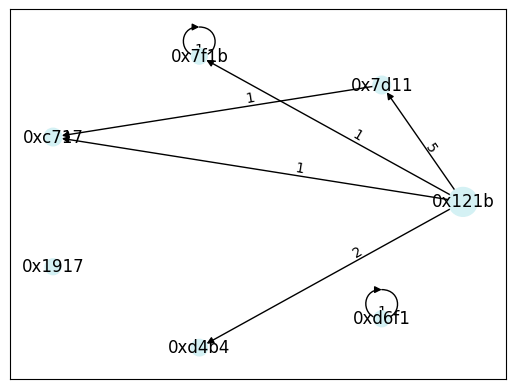

In [27]:
%%local
import networkx as nx
import matplotlib.pyplot as plt
pos = nx.circular_layout(G)
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
node_size=[(d['size'] * 10+100)
                 for u,d in G.nodes(data=True)]
print(len(edge_labels))
print(len(G.edges))
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, verticalalignment='bottom', label_pos=0.6)
nx.draw_networkx(G, pos=pos, node_color='#D4F1F4', node_size=node_size)
plt.show()

In [31]:
%%local
pos_ = nx.spring_layout(G)

In [8]:
%%local
# Custom function to create an edge between node x and node y, with a given text and width
def make_edge(x, y, text, width):
    return  go.Scatter(x         = x,
                       y         = y,
                       line      = dict(width = width,
                                   color = 'cornflowerblue'),
                       hoverinfo = 'text',
                       text      = ([text]),
                       mode      = 'lines')

In [9]:
%%local
# For each edge, make an edge_trace, append to list
edge_trace = []
for edge in G.edges():
    
    char_1 = edge[0]
    char_2 = edge[1]
    x0, y0 = pos_[char_1]
    x1, y1 = pos_[char_2]
    text   = '<b>' + str(G.edges()[edge]['weight']) + '<b>'
        
    trace  = make_edge([x0, x1, None], [y0, y1, None], text,
                            #width = 1)
                            width = 0.3*G.edges()[edge]['weight'])
    edge_trace.append(trace)

NameError: name 'pos_' is not defined

In [98]:
%%local
# Make a node trace
node_trace = go.Scatter(x         = [],
                        y         = [],
                        text      = [],
                        #textposition = "top center",
                        textfont_size = 10,
                        mode      = 'markers+text',
                        hoverinfo = 'none',
                        marker    = dict(color = [],
                                         size  = [],
                                         line  = None))
# For each node in midsummer, get the position and size and add to the node_trace
for node in G.nodes():
    x, y = pos_[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple(['cornflowerblue'])
    node_trace['marker']['size'] += tuple([5*G.nodes()[node]['size']])
    node_trace['text'] += tuple(['<b>' + node + '</b>'])

In [10]:
%%local

# Customize layout
layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
    yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
)
# Create figure
fig = go.Figure(layout = layout)
# Add all edge traces
for trace in edge_trace:
    fig.add_trace(trace)
# Add node trace
fig.add_trace(node_trace)
# Remove legend
fig.update_layout(showlegend = False)
# Remove tick labels
fig.update_xaxes(showticklabels = False)
fig.update_yaxes(showticklabels = False)
# Show figure


NameError: name 'go' is not defined

In [101]:
%%local
print(edge_trace)

[Scatter({
    'hoverinfo': 'text',
    'line': {'color': 'cornflowerblue', 'width': 0.3},
    'mode': 'lines',
    'text': [<b>1<b>],
    'x': [0.034845795136953975, -0.9999999999999999, None],
    'y': [-0.09910192431794619, -0.4042079931394343, None]
}), Scatter({
    'hoverinfo': 'text',
    'line': {'color': 'cornflowerblue', 'width': 0.3},
    'mode': 'lines',
    'text': [<b>1<b>],
    'x': [0.034845795136953975, 0.2709835900189038, None],
    'y': [-0.09910192431794619, -0.8169278095835374, None]
}), Scatter({
    'hoverinfo': 'text',
    'line': {'color': 'cornflowerblue', 'width': 0.3},
    'mode': 'lines',
    'text': [<b>1<b>],
    'x': [0.034845795136953975, -0.12834241319732798, None],
    'y': [-0.09910192431794619, 0.442141837853333, None]
}), Scatter({
    'hoverinfo': 'text',
    'line': {'color': 'cornflowerblue', 'width': 0.3},
    'mode': 'lines',
    'text': [<b>1<b>],
    'x': [0.034845795136953975, 0.9800401026046641, None],
    'y': [-0.09910192431794619, 0.432

11
11


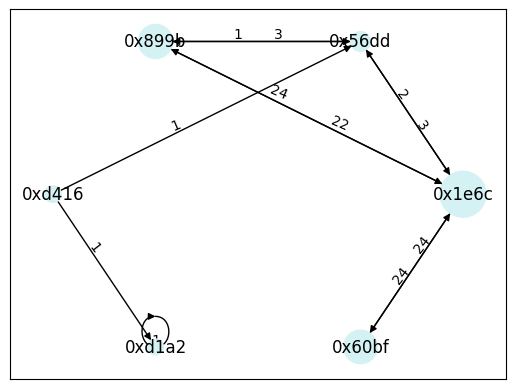

In [21]:
%%local
import networkx as nx
import matplotlib.pyplot as plt
pos = nx.circular_layout(G)
edge_labels=dict([((u,v,),d['weight'])
                 for u,v,d in G.edges(data=True)])
node_size=[(d['size'] * 10+100)
                 for u,d in G.nodes(data=True)]
print(len(edge_labels))
print(len(G.edges))
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, verticalalignment='bottom', label_pos=0.6)
nx.draw_networkx(G, pos=pos, node_color='#D4F1F4', node_size=node_size)
plt.show()